라이브러리 불러오기

In [2]:
!pip install pandas-datareader
!pip install finance-datareader
!pip install pykrx

     |████████████████████████████████| 81kB 5.4MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 256kB 11.9MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas_datareader import data as pdr
import FinanceDataReader as fdr
from pykrx import stock

import warnings 
warnings.filterwarnings('ignore')

### 공통함수

종목코드 검색 함수

In [4]:
def my_ticker(names):    
    df_code = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0]
    df_code.종목코드 = df_code.종목코드.map('{:06d}'.format)

    df_code = df_code[['회사명', '종목코드']]
    code_list = []
    for name in names:
        code = df_code.query("회사명=='{}'".format(name))['종목코드'].to_string(index=False)
        code = code.split(' ')[1]
        code_list.append(code)
    return code_list

In [5]:
def my_krx(start, end, *codes):
    df = pd.DataFrame()
    for code in codes:
        krx_df = stock.get_market_ohlcv_by_date('20100101', '20191231', code)
        krx_df.reset_index(inplace=True)
        krx_df.insert(loc=1, column='종목코드', value=code)
        krx_df.columns = ['date', 'code', 'open', 'high', 'low', 'close','volume']
        df[code] = krx_df     
    return df

In [6]:
stocks = ['삼성전자']
stock_code= my_ticker(stocks)
print(stock_code)
df = stock.get_market_ohlcv_by_date('20181201', '20210430', stock_code)
df.reset_index(inplace=True)
# df.insert(loc=1, column='종목코드', value=stock_code)
df.columns = ['date', 'open', 'high', 'low', 'close','volume']
df.head()

['005930']


,date,open,high,low,close,volume
0,2018-12-03,42750,43400,42400,43250,12110702
1,2018-12-04,42650,42900,41900,42150,14347746
2,2018-12-05,40900,41750,40850,41450,12631983
3,2018-12-06,40600,41100,40450,40500,14251826
4,2018-12-07,40900,41400,40850,40950,11433083


### 볼린저 밴드
* 20일치 이동평균선을 이용한 매수 매도 진입점 파악
* 상한선 : 볼린저밴드 +2편차볼린저밴드 =  20일 이평선/ 편차
* 하한선: 볼린저밴드 -2편차

ref = https://m.blog.naver.com/mymoneymoney/221508019985

In [7]:
df['m20']= df['close'].rolling(20).mean()
df['m20_std']= df['close'].rolling(20).std()
df['upper']= df['m20']+ df['m20_std']*2
df['lower']= df['m20']- df['m20_std']*2


In [8]:
df.dropna(inplace= True)
df['date']= pd.to_datetime(df['date'])
df.set_index('date', inplace= True)
df.head()

,open,high,low,close,volume,m20,m20_std,upper,lower
date,,,,,,,,,
2019-01-02,39400,39400,38550,38750,7847664,39772.5,1370.312584,42513.125169,37031.874831
2019-01-03,38300,38550,37450,37600,12471493,39490.0,1185.615541,41861.231082,37118.768918
2019-01-04,37450,37600,36850,37450,14108958,39255.0,1092.787358,41440.574717,37069.425283
2019-01-07,38000,38900,37800,38750,12748997,39120.0,966.872331,41053.744663,37186.255337
2019-01-08,38000,39200,37950,38100,12756554,39000.0,934.992260,40869.984520,37130.015480


In [9]:
SIZE_ =100

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


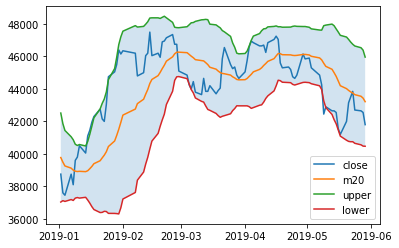

In [10]:
plt.plot(df['close'].iloc[:SIZE_], label = 'close')
plt.plot(df['m20'].iloc[:SIZE_], label= 'm20')
plt.plot(df['upper'].iloc[:SIZE_], label='upper')
plt.plot(df['lower'].iloc[:SIZE_], label= 'lower')
plt.fill_between(df.iloc[:SIZE_].index, df['upper'].iloc[:SIZE_], df['lower'].iloc[:SIZE_], alpha =0.2)
plt.legend()
plt.show()

주가 데이터 주기 설정

### **1. %b 지표**
* %b : 주가가 볼린저 밴드 영역 내 어느 곳에 위치해 있는지를 나타내는 지표

* %b  = (종가 - 볼린저밴드 하한선) / (볼린전밴드 상한선 - 볼린전밴드 하한선)



In [11]:
df['%b'] = (df['close']-df['lower'])/ (df['upper']-df['lower'])

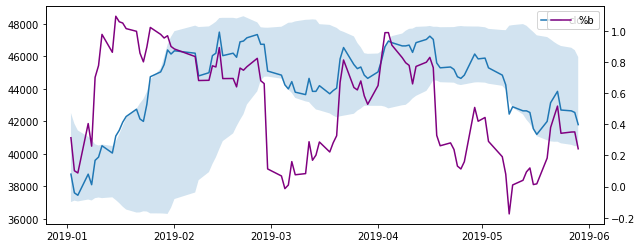

In [12]:
plt.figure(figsize= (10,4))
plt.plot(df['close'].iloc[:SIZE_], label = 'close')
# plt.plot(df['m20'].iloc[:SIZE_], label= 'm20')
# plt.plot(df['upper'].iloc[:SIZE_], label='upper')
# plt.plot(df['lower'].iloc[:SIZE_], label= 'lower')
plt.fill_between(df.iloc[:SIZE_].index, df['upper'].iloc[:SIZE_], df['lower'].iloc[:SIZE_], alpha =0.2)
plt.legend()

plt.twinx()
plt.plot(df['%b'].iloc[:SIZE_],label = '%b' , color = 'purple')
plt.legend()
plt.show()

* %b 수치는 주가의 흐름을 따른다.

### **2. 밴드 폭**

* 스퀴즈 파악에 유용
* 주가가 극도로 떨어져서 곧 반등세(상승세)를 보일 것으로 예상되는 상황
* 밴드폭 = (볼린저밴드 상한- 볼린저밴드 하한) / 볼린저밴드 중간 *100

In [13]:
df['bwidth'] = (df['upper']- df['lower']) / df['m20'] *100

In [14]:
df.head()

,open,high,low,close,volume,m20,m20_std,upper,lower,%b,bwidth
date,,,,,,,,,,,
2019-01-02,39400,39400,38550,38750,7847664,39772.5,1370.312584,42513.125169,37031.874831,0.313455,13.781508
2019-01-03,38300,38550,37450,37600,12471493,39490.0,1185.615541,41861.231082,37118.768918,0.101473,12.009274
2019-01-04,37450,37600,36850,37450,14108958,39255.0,1092.787358,41440.574717,37069.425283,0.087065,11.135268
2019-01-07,38000,38900,37800,38750,12748997,39120.0,966.872331,41053.744663,37186.255337,0.404331,9.886220
2019-01-08,38000,39200,37950,38100,12756554,39000.0,934.992260,40869.984520,37130.015480,0.259356,9.589664


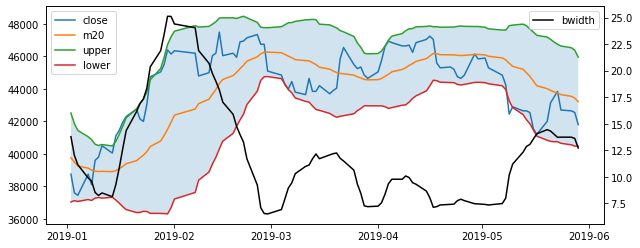

In [15]:
plt.figure(figsize= (10,4))
plt.plot(df['close'].iloc[:SIZE_], label = 'close')
plt.plot(df['m20'].iloc[:SIZE_], label= 'm20')
plt.plot(df['upper'].iloc[:SIZE_], label='upper')
plt.plot(df['lower'].iloc[:SIZE_], label= 'lower')
plt.fill_between(df.iloc[:SIZE_].index, df['upper'].iloc[:SIZE_], df['lower'].iloc[:SIZE_], alpha =0.2)
plt.legend()


plt.twinx()
# plt.plot(df['%b'].iloc[:SIZE_],label = '%b' , color = 'purple')
plt.plot(df['bwidth'].iloc[:SIZE_], label = 'bwidth', color = 'black')
plt.legend()
plt.show()

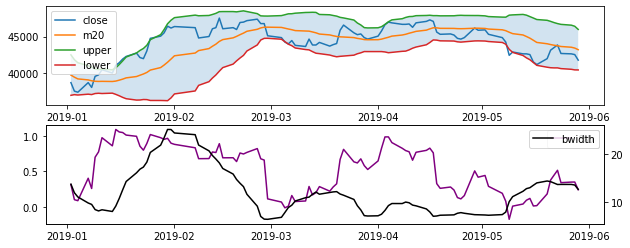

In [16]:
plt.figure(figsize= (10,4))
plt.subplot(2,1,1)
plt.plot(df['close'].iloc[:SIZE_], label = 'close')
plt.plot(df['m20'].iloc[:SIZE_], label= 'm20')
plt.plot(df['upper'].iloc[:SIZE_], label='upper')
plt.plot(df['lower'].iloc[:SIZE_], label= 'lower')
plt.fill_between(df.iloc[:SIZE_].index, df['upper'].iloc[:SIZE_], df['lower'].iloc[:SIZE_], alpha =0.2)
plt.legend()

plt.subplot(2,1,2)
plt.plot(df['%b'].iloc[:SIZE_],label = '%b' , color = 'purple')
plt.legend()
plt.twinx()
plt.plot(df['bwidth'].iloc[:SIZE_], label = 'bwidth', color = 'black')
plt.legend()
plt.show()

* 밴드폭이 크다는 것은 변동성이 크다는 것을 의미한다. 
* 밴드폭이 하한선과 반대로 움직인다 (밴드폭 최상 = = lower 최하)

## 볼린저 밴드 매매 전략
  * 변동성 돌파 전략 : 고위험 고수익
  * 추세 추종 : 추세가 상승세 일 때 매수, 추세가 하락세 일 때 매도 
  * 반전 : 반등세를 보이는 지점에서 매수 매도

### **3. 상대강도지수(RSI), 현금흐름지표(MFI)**

추세추종: 현금흐름지표(MFI, Money Flow Index)를 따른다. 
* MFI : 중심가격(고,저,종/3), 거래량
* MFI = 100 - (100/(1+ (긍정현금흐름/ 부정현금흐름)))
 - 긍정현금흐름 : 중심가가 전날보다 상승한 날들의 합
 - 부정현금흐름: 중심가가 전날보다 하락한 날들의 합

* RSI : 중심가격 변화량의 평균값

ref
- MFI:  https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=junhyung34&logNo=221606117183

- RSI:  https://ko.wikipedia.org/wiki/RSI_(%ED%88%AC%EC%9E%90%EC%A7%80%ED%91%9C)

In [17]:
df['mp'] = (df['high'] +df['low'] +df['close'])/3

#RMF 계산 = TP* 거래량
df['pos_mf'] = 0
df['neg_mf'] = 0

df['pos_mf'][df['mp'] >df['mp'].shift(1)] = df['mp']*df['volume']
df['neg_mf'][df['mp'] <df['mp'].shift(1)] = df['mp']*df['volume']

In [18]:
df['MFI'] = 100-(100/(1+(df.pos_mf.rolling(10).sum()/df.neg_mf.rolling(10).sum())))
df['MFI_5'] = 100-(100/(1+(df.pos_mf.rolling(5).sum()/df.neg_mf.rolling(5).sum())))

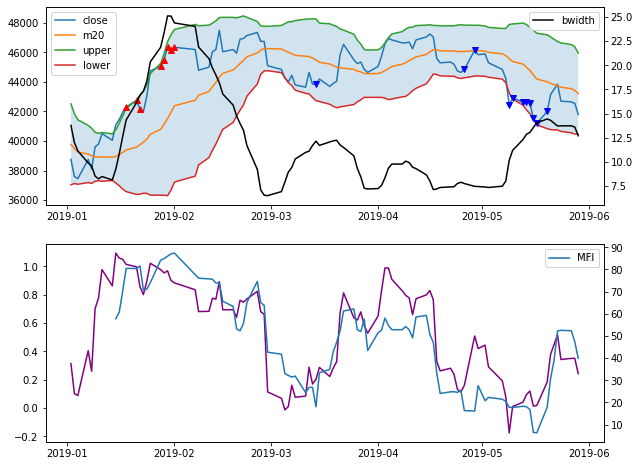

In [19]:
plt.figure(figsize= (10,8))
plt.subplot(2,1,1)
plt.plot(df['close'].iloc[:SIZE_], label = 'close')
plt.plot(df['m20'].iloc[:SIZE_], label= 'm20')
plt.plot(df['upper'].iloc[:SIZE_], label='upper')
plt.plot(df['lower'].iloc[:SIZE_], label= 'lower')
plt.fill_between(df.iloc[:SIZE_].index, df['upper'].iloc[:SIZE_], df['lower'].iloc[:SIZE_], alpha =0.2)
for i in range(SIZE_):
  if df[:SIZE_]['MFI'][i]>= 80:
    plt.plot(df[:SIZE_].index[i], df[:SIZE_]['close'][i], 'r^')
  elif df[:SIZE_]['MFI'][i] <= 20:
    plt.plot(df[:SIZE_].index[i], df[:SIZE_]['close'][i],'bv')
plt.legend()
plt.twinx()
plt.plot(df['bwidth'].iloc[:SIZE_], label = 'bwidth', color = 'black')
plt.legend()


plt.subplot(2,1,2)
plt.plot(df['%b'].iloc[:SIZE_],label = '%b' , color = 'purple')
plt.legend()
plt.twinx()
plt.plot(df['MFI'].iloc[:SIZE_], label= 'MFI')
plt.legend()
plt.show()

* %b (금액): 상한-하한
* MFI (거래량): 금액* 거래량
* MFI >= 80% 과잉매수, MFI <=20% 과잉매도

### **4. 반전**
* 일중강도(intraday Intensity Index):
종가 기준 자금 흐름 설명
  - (2종가-고가-저가)/(고가-저가)*거래량
  - Chaiken's Money Flow
  
  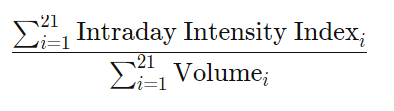

In [20]:
df['II'] = (2*df['close']-df['high']-df['low'])/(df['high']-df['low'])*df['volume']
df['II%'] = (df['II'].rolling(21).sum()/df['volume'].rolling(21).sum())*100

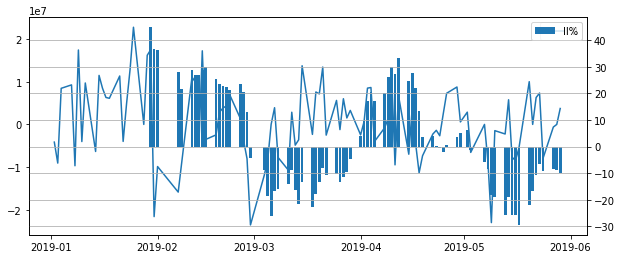

In [21]:
plt.figure(figsize = (10,4))

plt.plot(df['II'].iloc[:SIZE_], label= 'II')
plt.legend()
plt.twinx()

plt.bar(df.iloc[:SIZE_].index, df['II%'].iloc[:SIZE_], label='II%')
plt.legend()
plt.grid()
plt.show()

In [22]:
SIZE_ = 250

* 매수 : 주가가 하단 볼린저 밴드 부근에서 W형 패턴을 나타내고, 강세 지표가 확증할 때 매수 (%b가 0.05보다 작고, II%가 0보다 크면 매수)
* 매도 : 상단 볼린저 밴드 부근에서 일련의 주가 태그가 일어나며, 약세 지표가 확증할 때 매도 (%b가 0.95보다 크고 II%가 0보다 작으면 매도)

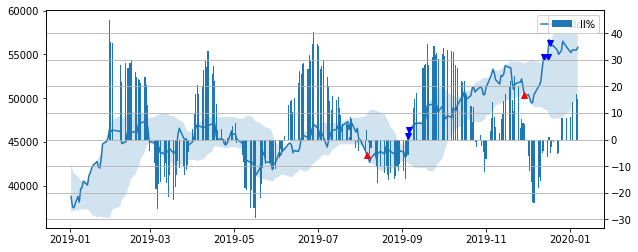

In [23]:
plt.figure(figsize=(10,4))
plt.plot(df['close'].iloc[:SIZE_], label = 'close')
plt.fill_between(df.iloc[:SIZE_].index, df['upper'].iloc[:SIZE_], df['lower'].iloc[:SIZE_], alpha =0.2)
plt.legend()
for i in range(SIZE_):
  if ((df[:SIZE_]['%b'][i]< 0.05) & (df[:SIZE_]['II%'][i]> 0)): #W형 매수신호
    plt.plot(df[:SIZE_].index[i], df[:SIZE_]['close'][i], 'r^')
  elif ((df[:SIZE_]['%b'][i] >0.95) & (df[:SIZE_]['II%'][i]< 0)): #M형 매도신호
    plt.plot(df[:SIZE_].index[i], df[:SIZE_]['close'][i],'bv')

plt.twinx()
plt.bar(df.iloc[:SIZE_].index, df['II%'].iloc[:SIZE_], label='II%')
plt.legend()

plt.grid()
plt.show()

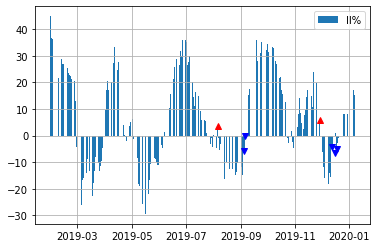

In [24]:
plt.bar(df.iloc[:SIZE_].index, df['II%'].iloc[:SIZE_], label='II%')

for i in range(SIZE_):
  if ((df[:SIZE_]['%b'][i]< 0.05) & (df[:SIZE_]['II%'][i]> 0)): #W형 매수신호
    plt.plot(df[:SIZE_].index[i], df[:SIZE_]['II%'][i], 'r^')
  elif ((df[:SIZE_]['%b'][i] >0.95) & (df[:SIZE_]['II%'][i]< 0)): #M형 매도신호
    plt.plot(df[:SIZE_].index[i], df[:SIZE_]['II%'][i],'bv')


plt.legend()
plt.grid()
plt.show()